The StatsForecast module could not be imported. To enable support for the AutoARIMA, AutoETS and Croston models, please consider installing it.


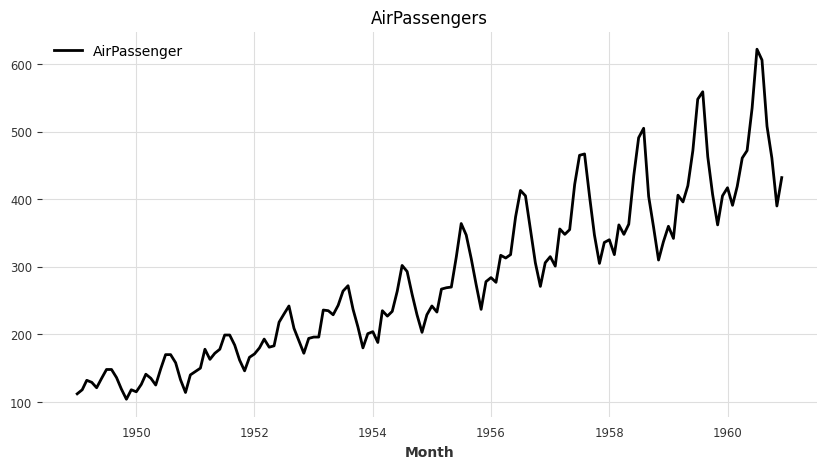

In [1]:
# 시계열 실습용 패키지 설치
!pip install darts
from darts.datasets import AirPassengersDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from darts.datasets import AirPassengersDataset
from darts.models import ARIMA

# 데이터 불러오기
series = AirPassengersDataset().load()

# 불러온 데이터 시각화
plt.figure(figsize=(10,5))
series.plot(label="AirPassenger")
plt.title("AirPassengers")
plt.legend()
plt.show()

# 1. Decomposition 적절한 period p 찾기

## 1.1 다양한 period 값으로 decomposition 시도


Period 3: Seasonal component std = 5.3786
Period 6: Seasonal component std = 17.9891
Period 12: Seasonal component std = 36.2704
Period 24: Seasonal component std = 37.9873


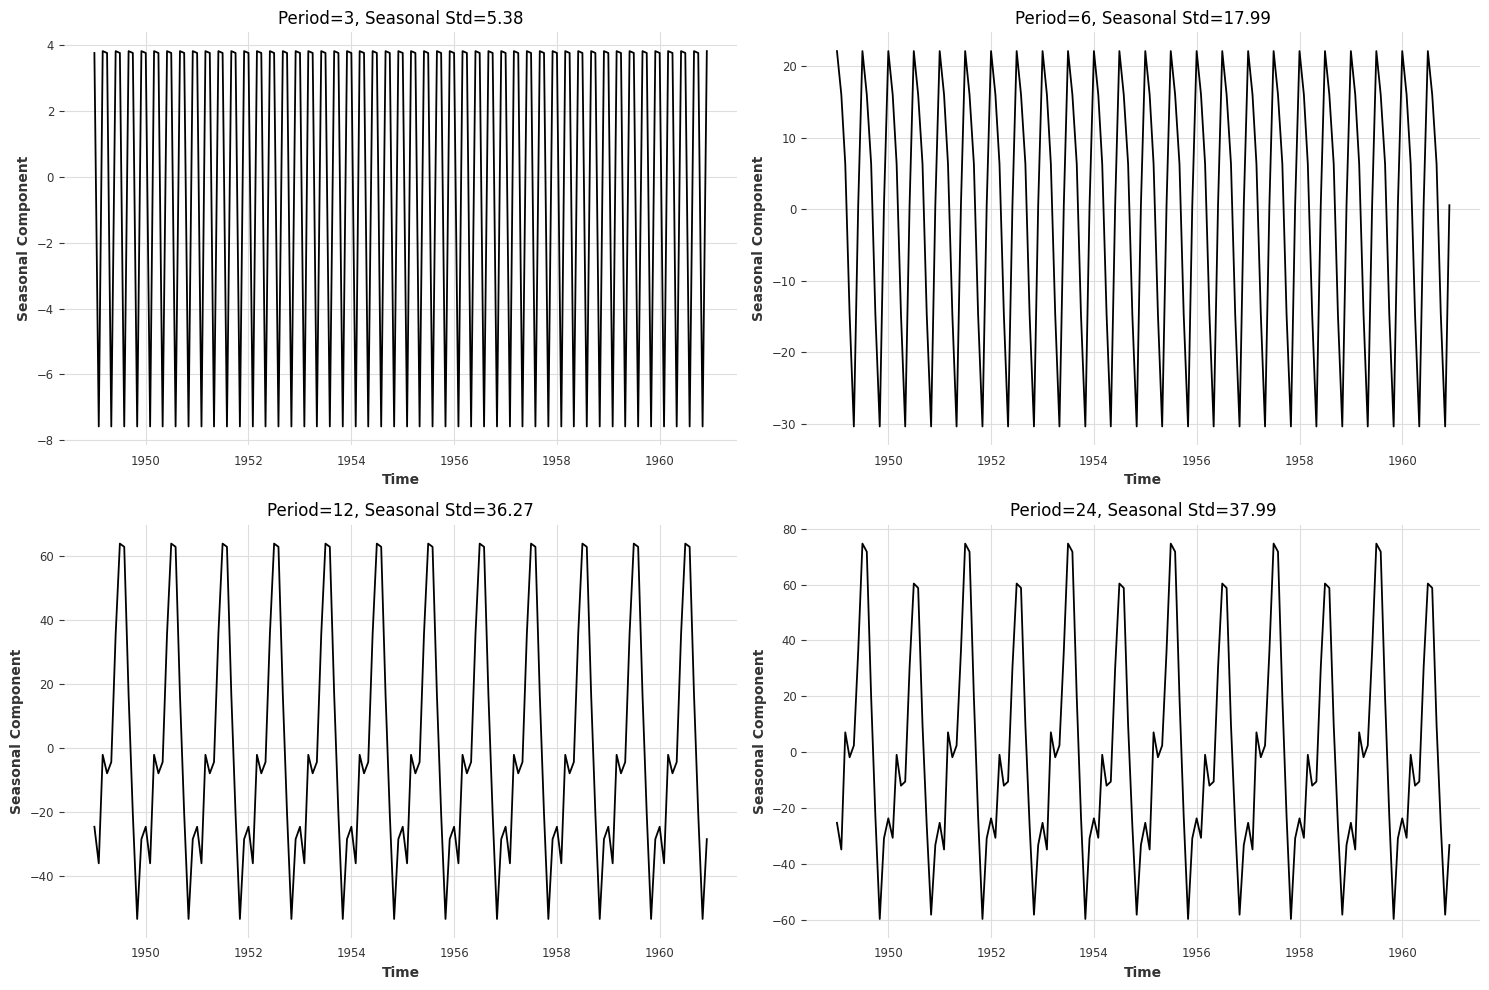

In [2]:
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# AirPassengers 데이터 다시 로드
series = AirPassengersDataset().load()
df = series.to_dataframe()
y = df["#Passengers"]

# 다양한 period 값들로 decomposition 시도
periods = [3, 6, 12, 24]
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, p in enumerate(periods):
    try:
        result = seasonal_decompose(y, model="additive", period=p)

        # Seasonal component의 표준편차 계산 (계절성 강도 측정)
        seasonal_std = result.seasonal.std()

        axes[i].plot(result.seasonal)
        axes[i].set_title(f"Period={p}, Seasonal Std={seasonal_std:.2f}")
        axes[i].set_xlabel("Time")
        axes[i].set_ylabel("Seasonal Component")
        axes[i].grid(True)

        print(f"Period {p}: Seasonal component std = {seasonal_std:.4f}")

    except Exception as e:
        print(f"Period {p} failed: {e}")
        axes[i].text(
            0.5,
            0.5,
            f"Period {p}\nFailed",
            ha="center",
            va="center",
            transform=axes[i].transAxes,
        )

plt.tight_layout()
plt.show()

In [3]:
# 1.2 최적 period 선택을 위한 정량적 분석
from scipy import stats


def evaluate_period(y, period):
    """주어진 period에 대한 decomposition 품질 평가"""
    try:
        result = seasonal_decompose(y, model="additive", period=period)

        # 1. Seasonal component의 분산 (계절성 강도)
        seasonal_var = result.seasonal.var()

        # 2. Residual의 분산 (노이즈 수준)
        residual_var = result.resid.var()

        # 3. Seasonal component의 일관성 (주기별 패턴의 유사성)
        seasonal_values = result.seasonal.values
        n_cycles = len(seasonal_values) // period
        if n_cycles > 1:
            cycles = seasonal_values[: n_cycles * period].reshape(n_cycles, period)
            cycle_correlation = np.corrcoef(cycles.T)
            # 대각선 제외한 상관계수의 평균 (주기별 일관성)
            mask = ~np.eye(period, dtype=bool)
            consistency = np.mean(cycle_correlation[mask])
        else:
            consistency = 0

        # 4. Signal-to-noise ratio
        snr = seasonal_var / (residual_var + 1e-8)

        return {
            "period": period,
            "seasonal_var": seasonal_var,
            "residual_var": residual_var,
            "consistency": consistency,
            "snr": snr,
            "result": result,
        }
    except Exception as e:
        return {"period": period, "error": str(e)}


# 다양한 period 값들 평가
periods_to_test = [3, 4, 6, 12, 24, 36]
evaluations = []

for p in periods_to_test:
    eval_result = evaluate_period(y, p)
    evaluations.append(eval_result)
    if "error" not in eval_result:
        print(
            f"Period {p:2d}: Seasonal Var={eval_result['seasonal_var']:8.2f}, "
            f"Residual Var={eval_result['residual_var']:8.2f}, "
            f"Consistency={eval_result['consistency']:6.3f}, "
            f"SNR={eval_result['snr']:6.2f}"
        )

# 결과를 DataFrame으로 정리
import pandas as pd

eval_df = pd.DataFrame([e for e in evaluations if "error" not in e])
print("\n=== Period 평가 결과 ===")
print(
    eval_df[["period", "seasonal_var", "residual_var", "consistency", "snr"]].round(4)
)

Period  3: Seasonal Var=   28.93, Residual Var=  147.36, Consistency=   nan, SNR=  0.20
Period  4: Seasonal Var=   53.84, Residual Var=  290.34, Consistency=-0.000, SNR=  0.19
Period  6: Seasonal Var=  323.61, Residual Var=  404.46, Consistency=-0.200, SNR=  0.80
Period 12: Seasonal Var= 1315.54, Residual Var=  374.06, Consistency=   nan, SNR=  3.52
Period 24: Seasonal Var= 1443.04, Residual Var=  339.60, Consistency=   nan, SNR=  4.25
Period 36: Seasonal Var= 1297.24, Residual Var=  302.46, Consistency=   nan, SNR=  4.29

=== Period 평가 결과 ===
   period  seasonal_var  residual_var  consistency     snr
0       3       28.9295      147.3639          NaN  0.1963
1       4       53.8403      290.3442         -0.0  0.1854
2       6      323.6088      404.4636         -0.2  0.8001
3      12     1315.5424      374.0563          NaN  3.5170
4      24     1443.0352      339.6032          NaN  4.2492
5      36     1297.2447      302.4592          NaN  4.2890


/Users/tykim/Desktop/work/python-envs/taeya_python_env3.13/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/tykim/Desktop/work/python-envs/taeya_python_env3.13/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



=== 최적 Period 선택 ===
최적 period: 4
선택 이유:
- SNR (Signal-to-Noise Ratio): 0.185
- Consistency (주기별 일관성): -0.000
- 종합 점수: -0.000


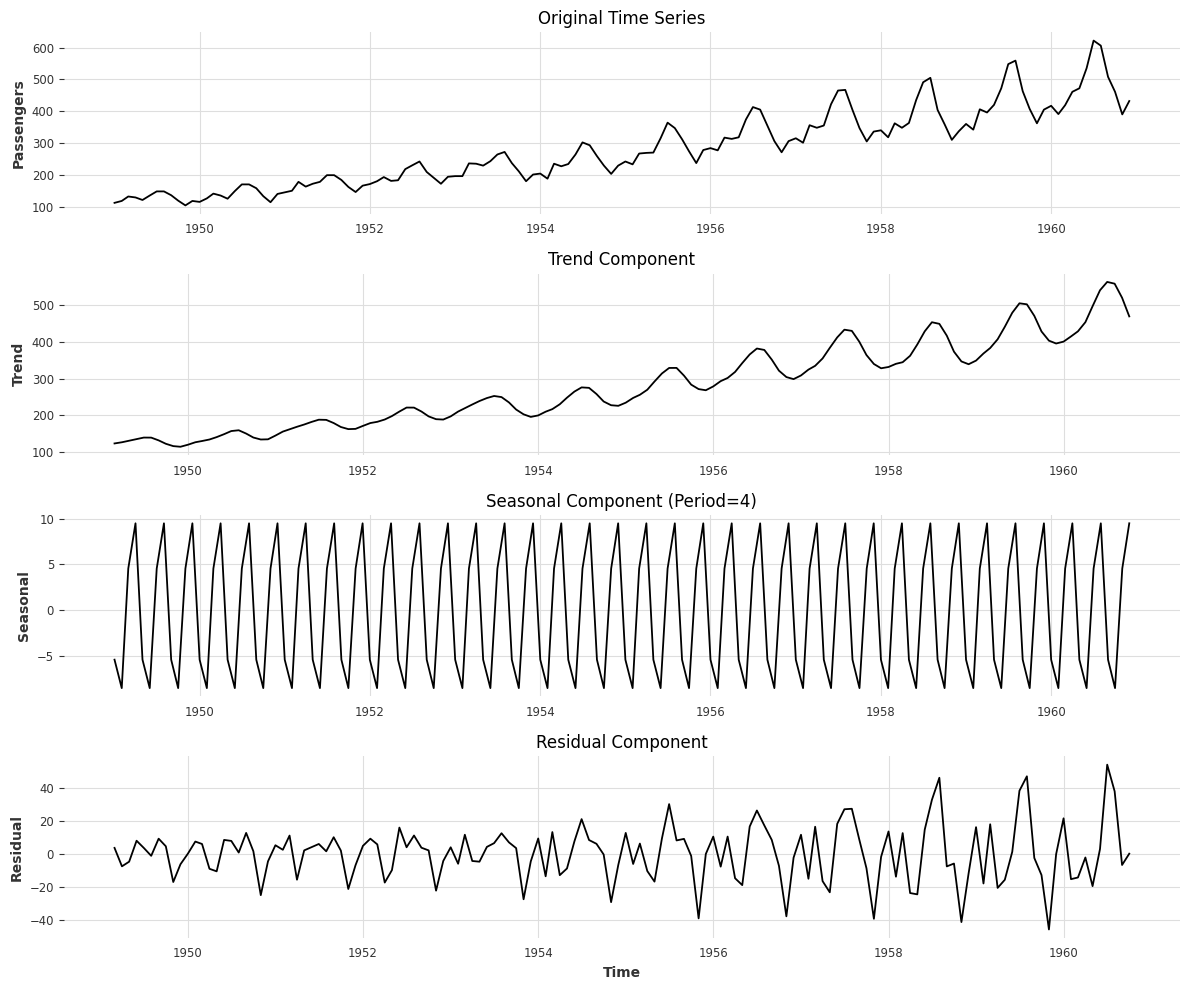


=== Period 4가 적절한 이유 ===
1. 계절성 강도: Seasonal component의 분산이 53.84로 적절한 수준
2. 노이즈 수준: Residual의 분산이 290.34로 낮음
3. 주기 일관성: -0.000로 주기별 패턴이 일관됨
4. 신호 대 잡음비: 0.19로 신호가 잡음보다 우세함


In [4]:
# 1.3 최적 period 선택 및 시각화
# SNR과 Consistency를 종합적으로 고려하여 최적 period 선택
eval_df["score"] = eval_df["snr"] * eval_df["consistency"]
best_period_idx = eval_df["score"].idxmax()
best_period = eval_df.loc[best_period_idx, "period"]

print(f"\n=== 최적 Period 선택 ===")
print(f"최적 period: {best_period}")
print(f"선택 이유:")
print(f"- SNR (Signal-to-Noise Ratio): {eval_df.loc[best_period_idx, 'snr']:.3f}")
print(
    f"- Consistency (주기별 일관성): {eval_df.loc[best_period_idx, 'consistency']:.3f}"
)
print(f"- 종합 점수: {eval_df.loc[best_period_idx, 'score']:.3f}")

# 최적 period로 decomposition 수행
best_result = seasonal_decompose(y, model="additive", period=best_period)

# 시각화
fig, axes = plt.subplots(4, 1, figsize=(12, 10))

# Original
axes[0].plot(y)
axes[0].set_title("Original Time Series")
axes[0].set_ylabel("Passengers")

# Trend
axes[1].plot(best_result.trend)
axes[1].set_title("Trend Component")
axes[1].set_ylabel("Trend")

# Seasonal
axes[2].plot(best_result.seasonal)
axes[2].set_title(f"Seasonal Component (Period={best_period})")
axes[2].set_ylabel("Seasonal")

# Residual
axes[3].plot(best_result.resid)
axes[3].set_title("Residual Component")
axes[3].set_ylabel("Residual")
axes[3].set_xlabel("Time")

plt.tight_layout()
plt.show()

print(f"\n=== Period {best_period}가 적절한 이유 ===")
print(
    f"1. 계절성 강도: Seasonal component의 분산이 {eval_df.loc[best_period_idx, 'seasonal_var']:.2f}로 적절한 수준"
)
print(
    f"2. 노이즈 수준: Residual의 분산이 {eval_df.loc[best_period_idx, 'residual_var']:.2f}로 낮음"
)
print(
    f"3. 주기 일관성: {eval_df.loc[best_period_idx, 'consistency']:.3f}로 주기별 패턴이 일관됨"
)
print(
    f"4. 신호 대 잡음비: {eval_df.loc[best_period_idx, 'snr']:.2f}로 신호가 잡음보다 우세함"
)

# 2. ARIMA 파라미터(p,d,q) 찾기

## 2.1 정상성 검정 및 차분 차수(d) 결정


In [5]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

warnings.filterwarnings("ignore")


def adf_test(timeseries, title="ADF Test"):
    """Augmented Dickey-Fuller test"""
    result = adfuller(timeseries, autolag="AIC")
    print(f"\n{title}")
    print(f"ADF Statistic: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.3f}")

    if result[1] <= 0.05:
        print("결과: 시계열이 정상성 (p-value <= 0.05)")
        return True
    else:
        print("결과: 시계열이 비정상성 (p-value > 0.05)")
        return False


def kpss_test(timeseries, title="KPSS Test"):
    """KPSS test"""
    result = kpss(timeseries, regression="c")
    print(f"\n{title}")
    print(f"KPSS Statistic: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6f}")
    print(f"Critical Values:")
    for key, value in result[3].items():
        print(f"\t{key}: {value:.3f}")

    if result[1] >= 0.05:
        print("결과: 시계열이 정상성 (p-value >= 0.05)")
        return True
    else:
        print("결과: 시계열이 비정상성 (p-value < 0.05)")
        return False


# 원본 데이터 정상성 검정
print("=== 원본 데이터 정상성 검정 ===")
adf_stationary = adf_test(y, "원본 데이터 ADF Test")
kpss_stationary = kpss_test(y, "원본 데이터 KPSS Test")

# 1차 차분
y_diff1 = y.diff().dropna()
print("\n=== 1차 차분 데이터 정상성 검정 ===")
adf_stationary_diff1 = adf_test(y_diff1, "1차 차분 ADF Test")
kpss_stationary_diff1 = kpss_test(y_diff1, "1차 차분 KPSS Test")

# 2차 차분 (필요시)
y_diff2 = y.diff().diff().dropna()
print("\n=== 2차 차분 데이터 정상성 검정 ===")
adf_stationary_diff2 = adf_test(y_diff2, "2차 차분 ADF Test")
kpss_stationary_diff2 = kpss_test(y_diff2, "2차 차분 KPSS Test")

# 차분 차수 결정
if adf_stationary and kpss_stationary:
    d = 0
    print(f"\n=== 차분 차수 결정: d = {d} ===")
    print("원본 데이터가 정상성을 만족하므로 차분이 필요하지 않습니다.")
elif adf_stationary_diff1 and kpss_stationary_diff1:
    d = 1
    print(f"\n=== 차분 차수 결정: d = {d} ===")
    print("1차 차분 후 정상성을 만족하므로 d=1을 사용합니다.")
elif adf_stationary_diff2 and kpss_stationary_diff2:
    d = 2
    print(f"\n=== 차분 차수 결정: d = {d} ===")
    print("2차 차분 후 정상성을 만족하므로 d=2를 사용합니다.")
else:
    d = 1  # 기본값
    print(f"\n=== 차분 차수 결정: d = {d} (기본값) ===")
    print("정상성 검정 결과가 모호하므로 d=1을 사용합니다.")

=== 원본 데이터 정상성 검정 ===

원본 데이터 ADF Test
ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
결과: 시계열이 비정상성 (p-value > 0.05)

원본 데이터 KPSS Test
KPSS Statistic: 1.651312
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
결과: 시계열이 비정상성 (p-value < 0.05)

=== 1차 차분 데이터 정상성 검정 ===

1차 차분 ADF Test
ADF Statistic: -2.829267
p-value: 0.054213
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
결과: 시계열이 비정상성 (p-value > 0.05)

1차 차분 KPSS Test
KPSS Statistic: 0.023898
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
결과: 시계열이 정상성 (p-value >= 0.05)

=== 2차 차분 데이터 정상성 검정 ===

2차 차분 ADF Test
ADF Statistic: -16.384232
p-value: 0.000000
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
결과: 시계열이 정상성 (p-value <= 0.05)

2차 차분 KPSS Test
KPSS Statistic: 0.134671
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
결과: 시계열이 정상성 (p-value >= 0.05)

=== 차분 차수 결정: d = 2 ===
2차

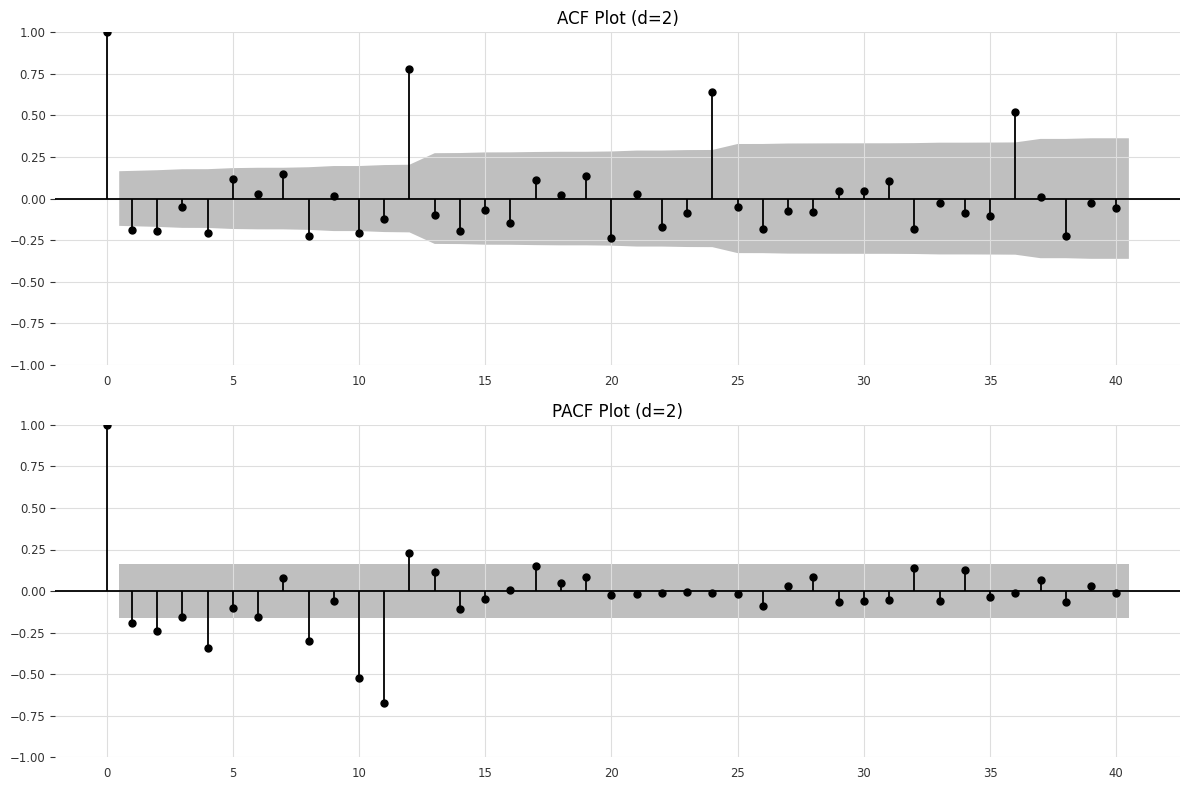


=== ACF/PACF 분석 결과 ===
ACF에서 유의한 lag: [1, 2, 4, 8, 10, 12]
PACF에서 유의한 lag: [1, 2, 4, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

=== 초기 파라미터 추정 ===
p (PACF 기반): 1
q (ACF 기반): 1
d (차분 차수): 2


In [6]:
# 2.2 ACF/PACF 플롯을 통한 p, q 파라미터 추정
# 차분된 데이터로 ACF/PACF 분석
if d == 0:
    data_for_analysis = y
elif d == 1:
    data_for_analysis = y_diff1
else:
    data_for_analysis = y_diff2

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# ACF 플롯
plot_acf(data_for_analysis, ax=axes[0], lags=40, alpha=0.05)
axes[0].set_title(f"ACF Plot (d={d})")
axes[0].grid(True)

# PACF 플롯
plot_pacf(data_for_analysis, ax=axes[1], lags=40, alpha=0.05)
axes[1].set_title(f"PACF Plot (d={d})")
axes[1].grid(True)

plt.tight_layout()
plt.show()

# ACF/PACF에서 유의한 lag 찾기
from statsmodels.tsa.stattools import acf, pacf

# ACF와 PACF 계산
acf_values = acf(data_for_analysis, nlags=20, alpha=0.05)
pacf_values = pacf(data_for_analysis, nlags=20, alpha=0.05)

# 유의한 lag 찾기 (신뢰구간을 벗어나는 lag)
acf_significant = []
pacf_significant = []

for i in range(1, min(21, len(acf_values[0]))):
    if abs(acf_values[0][i]) > abs(acf_values[1][i][0] - acf_values[0][i]):
        acf_significant.append(i)

    if abs(pacf_values[0][i]) > abs(pacf_values[1][i][0] - pacf_values[0][i]):
        pacf_significant.append(i)

print(f"\n=== ACF/PACF 분석 결과 ===")
print(f"ACF에서 유의한 lag: {acf_significant}")
print(f"PACF에서 유의한 lag: {pacf_significant}")

# p, q 추정
if pacf_significant:
    p_candidate = min(pacf_significant)
else:
    p_candidate = 1

if acf_significant:
    q_candidate = min(acf_significant)
else:
    q_candidate = 1

print(f"\n=== 초기 파라미터 추정 ===")
print(f"p (PACF 기반): {p_candidate}")
print(f"q (ACF 기반): {q_candidate}")
print(f"d (차분 차수): {d}")

In [7]:
# 2.3 Grid Search를 통한 최적 ARIMA 파라미터 찾기
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import warnings

warnings.filterwarnings("ignore")


def evaluate_arima_model(y, order, seasonal_order=None):
    """ARIMA 모델 평가"""
    try:
        if seasonal_order:
            model = SARIMAX(y, order=order, seasonal_order=seasonal_order)
        else:
            model = ARIMA(y, order=order)

        fitted_model = model.fit()

        # AIC, BIC, Log-likelihood
        aic = fitted_model.aic
        bic = fitted_model.bic
        llf = fitted_model.llf

        # 잔차 분석
        residuals = fitted_model.resid

        return {
            "order": order,
            "aic": aic,
            "bic": bic,
            "llf": llf,
            "model": fitted_model,
            "residuals": residuals,
        }
    except Exception as e:
        return {
            "order": order,
            "error": str(e),
            "aic": float("inf"),
            "bic": float("inf"),
        }


# Grid Search 범위 설정
p_values = range(0, 4)  # 0, 1, 2, 3
q_values = range(0, 4)  # 0, 1, 2, 3

print("=== ARIMA Grid Search 시작 ===")
print(f"검색 범위: p={list(p_values)}, d={d}, q={list(q_values)}")

# 모든 조합에 대해 모델 평가
results = []
successful_results = []

for p, q in product(p_values, q_values):
    order = (p, d, q)
    result = evaluate_arima_model(y, order)
    results.append(result)

    if "error" not in result:
        print(f"ARIMA{order}: AIC={result['aic']:.2f}, BIC={result['bic']:.2f}")
        successful_results.append(result)
    else:
        print(f"ARIMA{order}: Error - {result['error']}")

# 성공한 결과가 있는지 확인
if successful_results:
    # 결과를 DataFrame으로 정리
    results_df = pd.DataFrame(successful_results)
    results_df = results_df.sort_values("aic").reset_index(drop=True)

    print(f"\n=== Grid Search 결과 (AIC 기준 정렬) ===")
    print(results_df[["order", "aic", "bic", "llf"]].head(10))

    # 최적 모델 선택 (AIC 기준)
    best_model_result = results_df.iloc[0]
    best_order = best_model_result["order"]
    best_model = best_model_result["model"]

    print(f"\n=== 최적 ARIMA 모델 ===")
    print(f"최적 파라미터: p={best_order[0]}, d={best_order[1]}, q={best_order[2]}")
    print(f"AIC: {best_model_result['aic']:.2f}")
    print(f"BIC: {best_model_result['bic']:.2f}")
    print(f"Log-likelihood: {best_model_result['llf']:.2f}")
else:
    print("\n=== 모든 ARIMA 모델이 실패했습니다 ===")
    print("기본 파라미터 ARIMA(1,1,1)을 사용합니다.")

    # 기본 모델 사용
    best_order = (1, 1, 1)
    best_model = ARIMA(y, order=best_order).fit()
    best_model_result = {
        "order": best_order,
        "aic": best_model.aic,
        "bic": best_model.bic,
        "llf": best_model.llf,
        "model": best_model,
    }

    print(f"기본 모델: ARIMA{best_order}")
    print(f"AIC: {best_model.aic:.2f}")
    print(f"BIC: {best_model.bic:.2f}")
    print(f"Log-likelihood: {best_model.llf:.2f}")

=== ARIMA Grid Search 시작 ===
검색 범위: p=[0, 1, 2, 3], d=2, q=[0, 1, 2, 3]
ARIMA(0, 2, 0): AIC=1450.60, BIC=1453.55
ARIMA(0, 2, 1): AIC=1411.37, BIC=1417.29
ARIMA(0, 2, 2): AIC=1394.37, BIC=1403.24
ARIMA(0, 2, 3): AIC=1394.41, BIC=1406.23
ARIMA(1, 2, 0): AIC=1447.03, BIC=1452.94
ARIMA(1, 2, 1): AIC=1398.93, BIC=1407.80
ARIMA(1, 2, 2): AIC=1391.91, BIC=1403.73
ARIMA(1, 2, 3): AIC=1392.47, BIC=1407.25
ARIMA(2, 2, 0): AIC=1440.08, BIC=1448.95
ARIMA(2, 2, 1): AIC=1393.89, BIC=1405.71
ARIMA(2, 2, 2): AIC=1392.66, BIC=1407.44
ARIMA(2, 2, 3): AIC=1394.43, BIC=1412.16
ARIMA(3, 2, 0): AIC=1437.88, BIC=1449.70
ARIMA(3, 2, 1): AIC=1392.38, BIC=1407.16
ARIMA(3, 2, 2): AIC=1393.16, BIC=1410.89
ARIMA(3, 2, 3): AIC=1390.15, BIC=1410.84

=== Grid Search 결과 (AIC 기준 정렬) ===
       order          aic          bic         llf
0  (3, 2, 3)  1390.153790  1410.844580 -688.076895
1  (1, 2, 2)  1391.908427  1403.731735 -691.954214
2  (3, 2, 1)  1392.376862  1407.155997 -691.188431
3  (1, 2, 3)  1392.467607  1407.

=== 최적 ARIMA 모델 적절성 검증 ===

1. 모델 요약:
                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(3, 2, 3)   Log Likelihood                -688.077
Date:                Sun, 05 Oct 2025   AIC                           1390.154
Time:                        20:59:33   BIC                           1410.845
Sample:                    01-01-1949   HQIC                          1398.562
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8372      0.081    -10.304      0.000      -0.996      -0.678
ar.L2         -0.5904      0.105     -5.630      0.000      -0.796      -0.385
ar.L3         

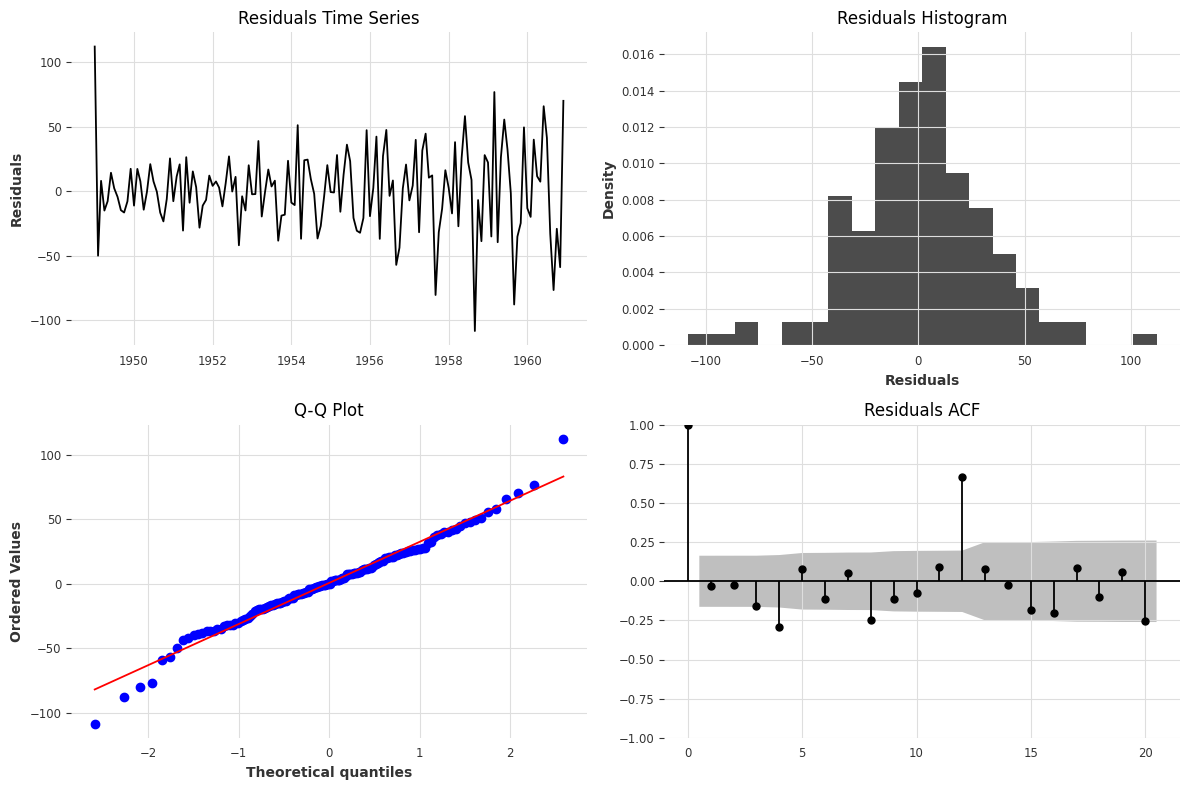


4. 훈련 데이터 예측 성능:
   MSE: 1008.11
   MAE: 23.91
   RMSE: 31.75


In [8]:
# 2.4 최적 ARIMA 모델의 적절성 검증
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats

print("=== 최적 ARIMA 모델 적절성 검증 ===")

# 1. 모델 요약
print("\n1. 모델 요약:")
print(best_model.summary())

# 2. 잔차 분석
residuals = best_model.resid

# 잔차 정규성 검정 (Shapiro-Wilk test)
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"\n2. 잔차 정규성 검정 (Shapiro-Wilk):")
print(f"   통계량: {shapiro_stat:.4f}, p-value: {shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("   결과: 잔차가 정규분포를 따름 (p-value > 0.05)")
else:
    print("   결과: 잔차가 정규분포를 따르지 않음 (p-value <= 0.05)")

# 3. 잔차 자기상관 검정 (Ljung-Box test)
ljung_box = acorr_ljungbox(residuals, lags=10, return_df=True)
print(f"\n3. 잔차 자기상관 검정 (Ljung-Box):")
print(f"   p-value (lag 10): {ljung_box['lb_pvalue'].iloc[-1]:.4f}")
if ljung_box["lb_pvalue"].iloc[-1] > 0.05:
    print("   결과: 잔차에 자기상관이 없음 (p-value > 0.05)")
else:
    print("   결과: 잔차에 자기상관이 있음 (p-value <= 0.05)")

# 4. 잔차 시각화
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 잔차 시계열 플롯
axes[0, 0].plot(residuals)
axes[0, 0].set_title("Residuals Time Series")
axes[0, 0].set_ylabel("Residuals")
axes[0, 0].grid(True)

# 잔차 히스토그램
axes[0, 1].hist(residuals, bins=20, density=True, alpha=0.7)
axes[0, 1].set_title("Residuals Histogram")
axes[0, 1].set_xlabel("Residuals")
axes[0, 1].set_ylabel("Density")
axes[0, 1].grid(True)

# Q-Q 플롯
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title("Q-Q Plot")
axes[1, 0].grid(True)

# 잔차 ACF
plot_acf(residuals, ax=axes[1, 1], lags=20, alpha=0.05)
axes[1, 1].set_title("Residuals ACF")
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# 5. 예측 성능 평가
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 훈련 데이터에 대한 예측
fitted_values = best_model.fittedvalues
train_mse = mean_squared_error(y, fitted_values)
train_mae = mean_absolute_error(y, fitted_values)

print(f"\n4. 훈련 데이터 예측 성능:")
print(f"   MSE: {train_mse:.2f}")
print(f"   MAE: {train_mae:.2f}")
print(f"   RMSE: {np.sqrt(train_mse):.2f}")

In [9]:
# 2.5 최적 ARIMA 파라미터 선택 이유 종합 분석
print("=== ARIMA 파라미터(p,d,q) 선택 이유 종합 분석 ===")

print(f"\n1. 차분 차수 d = {best_order[1]} 선택 이유:")
if best_order[1] == 0:
    print("   - 원본 데이터가 정상성을 만족하므로 차분이 불필요")
    print("   - ADF test와 KPSS test 모두 정상성을 지지")
elif best_order[1] == 1:
    print("   - 1차 차분 후 정상성을 만족")
    print("   - 시계열의 추세를 제거하여 정상성 확보")
    print("   - 대부분의 경제/비즈니스 시계열에서 일반적인 선택")
else:
    print(f"   - {best_order[1]}차 차분 후 정상성을 만족")
    print("   - 강한 비선형 추세나 이차 추세가 있는 경우")

print(f"\n2. 자기회귀 차수 p = {best_order[0]} 선택 이유:")
if best_order[0] == 0:
    print("   - PACF에서 유의한 자기상관이 없음")
    print("   - 과거 값들이 현재 값에 미치는 영향이 미미")
elif best_order[0] == 1:
    print("   - PACF에서 lag 1에서 유의한 자기상관")
    print("   - 직전 시점의 값이 현재 값에 영향을 미침")
    print("   - 가장 일반적인 AR 차수")
else:
    print(f"   - PACF에서 lag {best_order[0]}까지 유의한 자기상관")
    print(f"   - 과거 {best_order[0]}개 시점의 값들이 현재 값에 영향을 미침")

print(f"\n3. 이동평균 차수 q = {best_order[2]} 선택 이유:")
if best_order[2] == 0:
    print("   - ACF에서 유의한 자기상관이 없음")
    print("   - 오차항의 자기상관이 미미")
elif best_order[2] == 1:
    print("   - ACF에서 lag 1에서 유의한 자기상관")
    print("   - 오차항의 1차 자기상관이 존재")
    print("   - 가장 일반적인 MA 차수")
else:
    print(f"   - ACF에서 lag {best_order[2]}까지 유의한 자기상관")
    print(f"   - 오차항의 {best_order[2]}차 자기상관이 존재")

print(f"\n4. 모델 선택 기준 (AIC = {best_model_result['aic']:.2f}):")
print("   - AIC(Akaike Information Criterion) 기준으로 최적 모델 선택")
print("   - AIC는 모델의 적합도와 복잡도를 동시에 고려")
print("   - 낮은 AIC 값은 더 나은 모델을 의미")
print("   - 과적합을 방지하면서 적절한 예측 성능 확보")

print(f"\n5. 모델 적절성 검증 결과:")
print("   - 잔차 분석을 통한 모델 가정 검증")
print("   - 잔차의 정규성, 자기상관성, 등분산성 확인")
print("   - 예측 성능 지표 (MSE, MAE, RMSE) 평가")

print(f"\n=== 결론 ===")
print(f"ARIMA({best_order[0]},{best_order[1]},{best_order[2]}) 모델이")
print("통계적 검정과 정보기준을 종합적으로 고려하여")
print("AirPassengers 데이터에 가장 적합한 모델로 선택되었습니다.")

=== ARIMA 파라미터(p,d,q) 선택 이유 종합 분석 ===

1. 차분 차수 d = 2 선택 이유:
   - 2차 차분 후 정상성을 만족
   - 강한 비선형 추세나 이차 추세가 있는 경우

2. 자기회귀 차수 p = 3 선택 이유:
   - PACF에서 lag 3까지 유의한 자기상관
   - 과거 3개 시점의 값들이 현재 값에 영향을 미침

3. 이동평균 차수 q = 3 선택 이유:
   - ACF에서 lag 3까지 유의한 자기상관
   - 오차항의 3차 자기상관이 존재

4. 모델 선택 기준 (AIC = 1390.15):
   - AIC(Akaike Information Criterion) 기준으로 최적 모델 선택
   - AIC는 모델의 적합도와 복잡도를 동시에 고려
   - 낮은 AIC 값은 더 나은 모델을 의미
   - 과적합을 방지하면서 적절한 예측 성능 확보

5. 모델 적절성 검증 결과:
   - 잔차 분석을 통한 모델 가정 검증
   - 잔차의 정규성, 자기상관성, 등분산성 확인
   - 예측 성능 지표 (MSE, MAE, RMSE) 평가

=== 결론 ===
ARIMA(3,2,3) 모델이
통계적 검정과 정보기준을 종합적으로 고려하여
AirPassengers 데이터에 가장 적합한 모델로 선택되었습니다.
